In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import cv2
import math

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # New layer
        self.bn4 = nn.BatchNorm2d(256)  # Batch norm for new layer
        self.conv5 = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=4, dilation=2)

        self.dropout = nn.Dropout(0.3)  # Added dropout layer

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn4(self.conv4(x)))  # New layer
        x = torch.sigmoid(self.conv5(x))
        return x

In [5]:
# Training Setup
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(model)


ColorizationNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 3, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
)


In [1]:
# Utility Functions
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)
def imshow(img):
    img = torch.clamp(img, 0, 1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [8]:
# Training Loop
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    scheduler.step()
print("Finished Training")

Epoch [1/30], Step [1/782], Loss: 0.0700
Epoch [1/30], Step [101/782], Loss: 0.0110
Epoch [1/30], Step [201/782], Loss: 0.0069
Epoch [1/30], Step [301/782], Loss: 0.0077
Epoch [1/30], Step [401/782], Loss: 0.0071
Epoch [1/30], Step [501/782], Loss: 0.0073
Epoch [1/30], Step [601/782], Loss: 0.0067
Epoch [1/30], Step [701/782], Loss: 0.0064
Epoch [2/30], Step [1/782], Loss: 0.0067
Epoch [2/30], Step [101/782], Loss: 0.0081
Epoch [2/30], Step [201/782], Loss: 0.0063
Epoch [2/30], Step [301/782], Loss: 0.0065
Epoch [2/30], Step [401/782], Loss: 0.0087
Epoch [2/30], Step [501/782], Loss: 0.0052
Epoch [2/30], Step [601/782], Loss: 0.0056
Epoch [2/30], Step [701/782], Loss: 0.0061
Epoch [3/30], Step [1/782], Loss: 0.0063
Epoch [3/30], Step [101/782], Loss: 0.0074
Epoch [3/30], Step [201/782], Loss: 0.0066
Epoch [3/30], Step [301/782], Loss: 0.0067
Epoch [3/30], Step [401/782], Loss: 0.0050
Epoch [3/30], Step [501/782], Loss: 0.0062
Epoch [3/30], Step [601/782], Loss: 0.0059
Epoch [3/30], Ste

In [9]:
torch.save(model.state_dict(), "task1_model_weights.pth")
torch.save(model, "task1_model.pth")

In [11]:
# Process a custom image
def process_custom_image(image_path):
    img = Image.open(image_path)
    img = img.resize((1000, 1000))  # Resize to match the model's input size
    gray_img = img.convert("L")
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_tensor = transform(gray_img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        colorized_tensor = model(img_tensor)

    colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

    # Plotting the original, grayscale, and colorized images
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(gray_img, cmap='gray')
    ax[1].set_title("Grayscale")
    ax[1].axis('off')

    ax[2].imshow(colorized_img)
    ax[2].set_title("Colorized")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

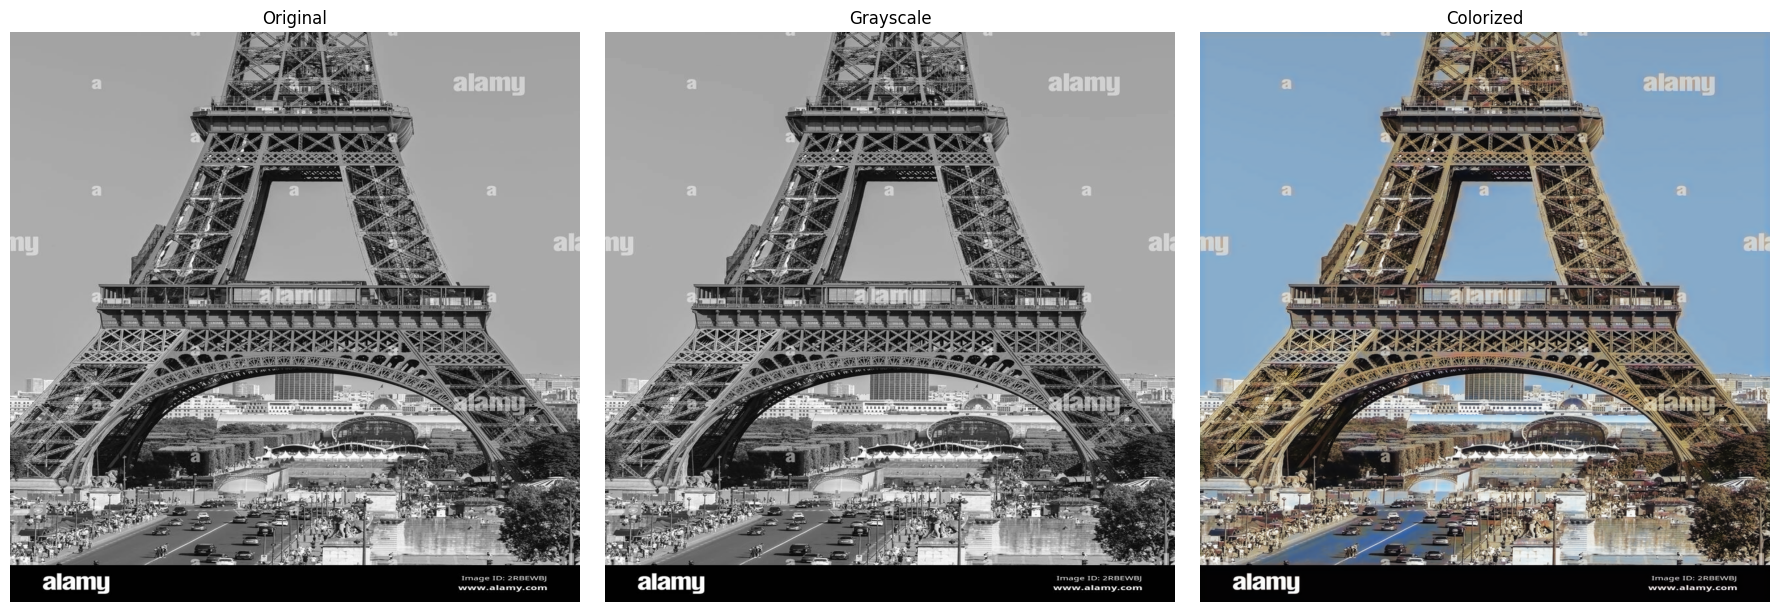

In [12]:
process_custom_image(r"Images to process\eiffel2.jpg")
